# Introducción



El presente proyecto corresponde a un radar de onda continua modulada en frecuencia (FMCW). 
Se presentamos una breve descripción de la teoría de funcionamiento del sistema FMCW y de cada componente utilizado. 
Luego se presenta el procedimiento de diseño para cada componente junto con los resultados experimentales de los componentes fabricados. La frecuencia de operación fue elegida para ser 925 MHz, o alrededor de 1 GHz. 
Esta decisión se tomó por múltiples razones. 
Primero, la frecuencia está dentro de una banda ISM. 
En segundo lugar, esto permitió la fácil fabricación de circuitos de línea de transmisión de microondas ($1/4$ es aproximadamente $40 mm$) y también la soldadura manual de componentes discretos para terminación y polarización del amplificador. 
La operación en la banda ISM de $2,4 GHz$ para aplicaciones fuera de América del Norte es un simple cambio de frecuencia en los objetivos de diseño, pero la teoría sigue siendo la misma.

Este trabajo está inspirado en el "Coffee Can Radar".

## Teoría FMCW

El radar FMCW es un radar simple que puede medir la distancia de un objeto estático y la velocidad de un objeto en movimiento. El principio básico de cualquier radar es emitir una señal electromagnética y medir su reflejo desde un objetivo, Fig. 1(a). 
El reflejo se produce debido a la superficie metálica del objetivo que dispersa energía en todas las direcciones, una pequeña cantidad de la cual recibe el Radar. 
El radar más simple sería emitir una onda continua y medir la señal reflejada o dispersada. 
El problema es que la señal recibida tendría la misma frecuencia que la señal transmitida, con solo una diferencia de fase. Esto daría como resultado que solo se pudiera estimar la distancia como

$$d = n \cdot \lambda +\lambda \frac{\phi}{2 \pi}$$ 

donde: 

$d$ es la distancia estimada, 

$n$ es cualquier valor entero, 

$\lambda$ es la longitud de onda y 

$\phi$ es la diferencia de fase entre las señales transmitida y recibida. 

Como se puede ver, la distancia es ambigua, ya que la distancia podría ser cualquier múltiplo entero, $n$, de la longitud de onda. 
Además, un sistema de este tipo sería sensible a los retardos de fase y de trayectos múltiples en el hardware de transmisión y recepción. 
Sin embargo, la velocidad de un objetivo en movimiento podría medirse con este simple radar debido al desplazamiento Doppler, donde la diferencia de frecuencia está directamente relacionada con la velocidad del objeto:

$$\Delta f =2 f_o \frac{v}{c}$$ 

donde: 

$f_o$ es la frecuencia de transmisión, 

$v$ es la velocidad del objeto y 

$c$ es la velocidad de la luz.

Una solución al problema de la ambigüedad de la distancia es utilizar un radar de barrido de frecuencia, como un radar FMCW. 



La distancia del objetivo $d$ dará como resultado una señal reflejada que se mide a partir de $t$, donde t es la suma del tiempo de viaje de la señal de transmisión saliente, que se envía desde el radar al objetivo, y el tiempo de retorno de la transmisión de la señal, que se refleja desde el objetivo de vuelta al radar. 
Debido a esta diferencia, la señal recibida se desplazará en el tiempo. 
Cuando la señal regrese al receptor, estará en una frecuencia diferente a la frecuencia de transmisión ya que el VCO ha cambiado de frecuencia durante $t$. 
Este cambio de frecuencia se puede usar para determinar la distancia absoluta sin ambigüedad. 

La distancia es

$$d = c \frac{\Delta t}{2}$$

donde

$$\Delta t =  \frac{\Delta f}{m}$$

y $m$ es la pendiente de la rampa de frecuencia en $Hz/s$, 


![fig1](fig/esquema_completo.png)


La figura 1 muestra el diseño básico del sistema de un radar FMCW. 
Un oscilador controlado por voltaje (VCO) es barrido entre dos frecuencias por una rampa lineal. 
La función de transferencia de voltaje-frecuencia del VCO junto con la rampa de la señal de control determinarán la pendiente, $m$. 
La función de transferencia de voltaje-frecuencia de un VCO es típicamente no lineal; por lo tanto, una señal de control lineal no dará como resultado un barrido de frecuencia lineal. 
Para diseños de primer orden, esto puede ignorarse. 

La señal de salida del VCO se alimenta a un amplificador de potencia (PA), donde se amplifica la señal. 
Luego, la señal de salida del PA se divide mediante un divisor en una señal de potencia y una señal de oscilador local (LO). 
El divisor en este diseño es un acoplador  acoplado al borde con un acoplamiento de aproximadamente -15 dB, que se muestra en la Fig. 1 (d), de modo que el LO está 15 dB por debajo de la señal de potencia. 
La señal de potencia se envía a una antena de banda ancha. 
Para este diseño, elegimos una antena Vivaldi antípoda, que es fácil de construir y tiene un ancho de banda amplio. 
El receptor es una segunda antena que alimenta un amplificador de bajo ruido (LNA), que se muestra en la Fig 1. La salida del LNA luego se pasa a banda base mediante un mezclador, usando la señal LO producida por el divisor. Luego, la señal convertida por el mezclador se filtra y amplifica para medirla. 



![fig1](fig/fig2.png)

In [3]:
from scipy.signal import chirp, spectrogram
import matplotlib.pyplot as plt
import numpy as np

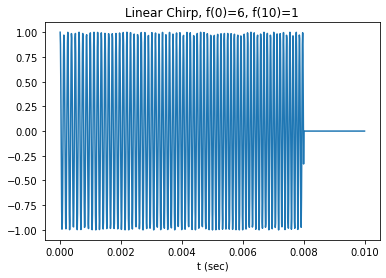

In [40]:
# Setting standard  requirements.
fs     = 100e3       

# Creating the data for filteration
T = 0.01         # value taken in seconds
n = int(T * fs) # indicates total samples
t = np.linspace(0, T, n, endpoint=False)

Tdelay = 2e-3
nd     = int(Tdelay * fs) 

tx = chirp(t[:-nd], f0=8e3, f1=10e3, t1=T, method='linear')
tx = np.append(tx,np.zeros(nd))

plt.plot(t, tx)
plt.title("Linear Chirp, f(0)=6, f(10)=1")
plt.xlabel('t (sec)')
plt.show()




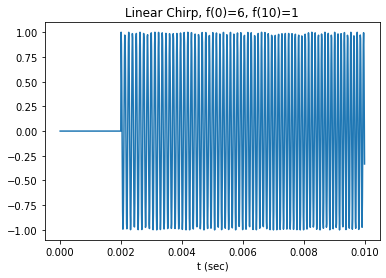

In [41]:
rx = np.zeros(nd)
rx = np.append(rx,tx[:-nd])

plt.plot(t, rx)
plt.title("Linear Chirp, f(0)=6, f(10)=1")
plt.xlabel('t (sec)')
plt.show()

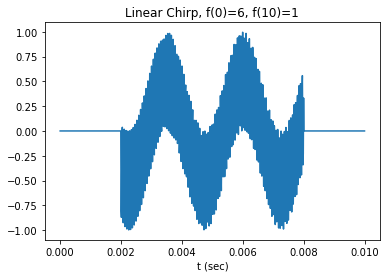

In [42]:
bb = tx*rx

plt.plot(t, bb)
plt.title("Linear Chirp, f(0)=6, f(10)=1")
plt.xlabel('t (sec)')
plt.show()

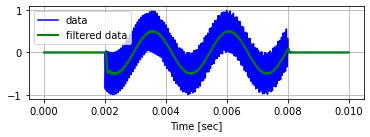

In [43]:
from scipy.signal import butter, lfilter, freqz


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y



# Setting standard filter requirements.
order  = 6
cutoff = 10e3  


# Filtering and plotting
y = butter_lowpass_filter(bb, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, bb, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()
